In [899]:
from qiskit_aer import Aer, AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import *
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
import numpy as np

from qiskit.quantum_info import SparsePauliOp

from qiskit.quantum_info import Statevector, Pauli, DensityMatrix, partial_trace

import matplotlib.pyplot as plt
from qiskit.visualization import plot_bloch_vector, plot_bloch_multivector, plot_state_paulivec, plot_state_qsphere

import qiskit.circuit.library.phase_estimation as PhaseEstimation

from qiskit.circuit.library import IGate, XGate, YGate, ZGate

from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise.errors import depolarizing_error
from qiskit_aer.noise.errors import QuantumError

In [915]:
def decimal_to_binary(decimal_num):
    """Converts a decimal integer to its binary representation (string).

    Args:
        decimal_num: The decimal integer to convert.

    Returns:
        The binary representation of the decimal number as a string.
    """
    if decimal_num == 0:
        return "0"

    binary_string = ""
    while decimal_num > 0:
        remainder = decimal_num % 2
        binary_string = str(remainder) + binary_string
        decimal_num //= 2
    return binary_string

def get_phase(sv_arr):
    states = sv_arr[sv_arr != np.complex128(0)]
    a = np.angle(states)
    return max(a)

p_strs = ['IIIII', 'IIZXZ', 'IXIYY', 'IXZZX', 'IYXXY', 'IYYIX', 'IZXZI', 'IZYYZ', 'XIXZZ', 'XIYYI', 'XXXXX', 'XXYIY', 'XYIYX', 'XYZZY', 'XZIIZ', 'XZZXI', 'YIXIY', 'YIYXX', 'YXXYI', 'YXYZZ', 'YYIXI', 'YYZIZ', 'YZIZY', 'YZZYX', 'ZIIZX', 'ZIZYY', 'ZXIXZ', 'ZXZII', 'ZYXYZ', 'ZYYZI', 'ZZXIX', 'ZZYXY']
exp_ref = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, -1]
def check_state(sv):
    exps = []
    for p in p_strs:
        exp = sv.expectation_value(SparsePauliOp(p))
        if exp > 0:
            exps.append(1)
        elif exp < 0:
            exps.append(-1)
    if len(exps) != 32:
        print('error')
        return
    else:
        return exp_ref == exps

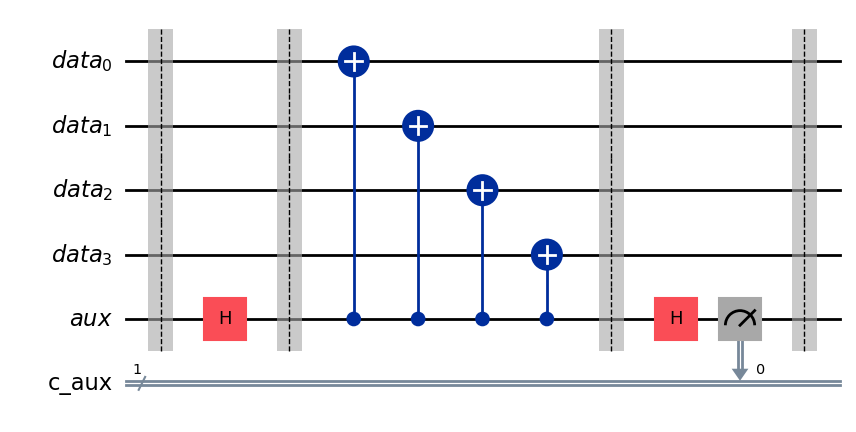

In [139]:
# looks at the Non-destructive stabilizer measurements
aux = QuantumRegister(1, 'aux') 
data = QuantumRegister(4, 'data') 
c_aux = ClassicalRegister(1, 'c_aux')
circuit0 = QuantumCircuit(data, aux, c_aux)

circuit0.barrier()
circuit0.h(aux[0])
circuit0.barrier()
for i in range(4):
    circuit0.cx(aux[0], data[i])
circuit0.barrier()
circuit0.h(aux[0])
circuit0.measure(aux[0], c_aux[0])
circuit0.barrier()
circuit0.draw('mpl')

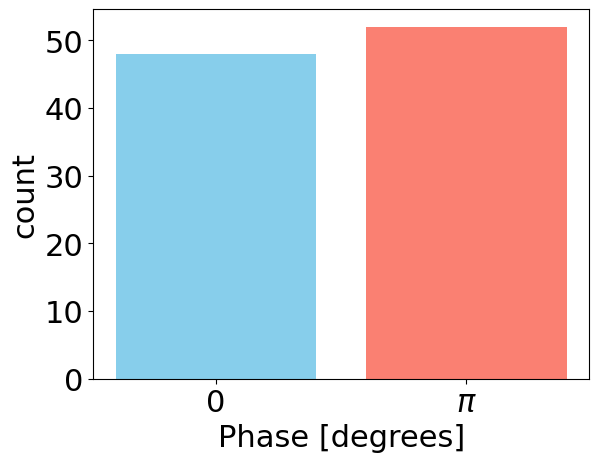

In [140]:
phases = []
for i in range(100):
    statevector_simulator = Aer.get_backend('statevector_simulator')
    job_sv = statevector_simulator.run(transpile(circuit0, statevector_simulator), shots=1000)
    result_sv = job_sv.result()
    statevector = np.array(result_sv.get_statevector())
    phases.append(get_phase(statevector))
phases = np.array(phases)
zeros = phases[phases == 0]
pis = phases[phases > 0]
plt.figure()
plt.xlabel('Phase [degrees]')
plt.ylabel('count')
plt.bar(['0', r'$\pi$'], [len(zeros), len(pis)], color=['skyblue', 'salmon'])
plt.show()


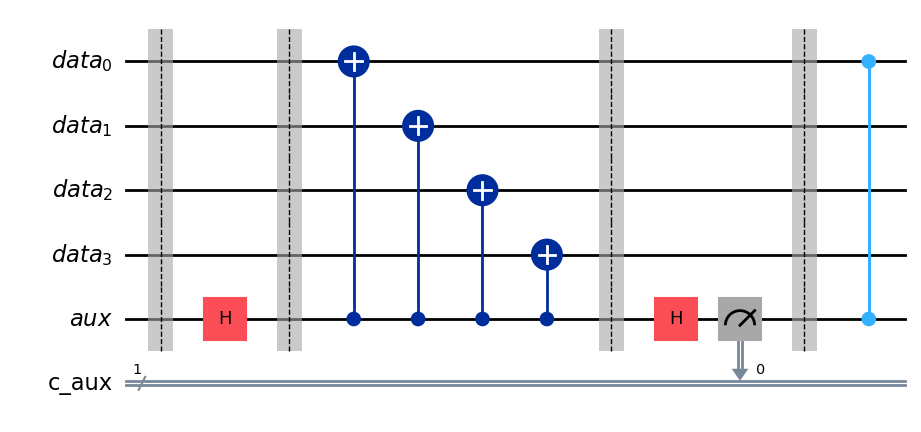

In [141]:
# looks at the Non-destructive stabilizer measurements
aux = QuantumRegister(1, 'aux') 
data = QuantumRegister(4, 'data') 
c_aux = ClassicalRegister(1, 'c_aux')
circuit1 = QuantumCircuit(data, aux, c_aux)

circuit1.barrier()
circuit1.h(aux[0])
circuit1.barrier()
for i in range(4):
    circuit1.cx(aux[0], data[i])
circuit1.barrier()
circuit1.h(aux[0])
circuit1.measure(aux[0], c_aux[0])
circuit1.barrier()
#circuit1.z(data[0])
circuit1.cz(aux[0], data[0])
circuit1.draw('mpl')


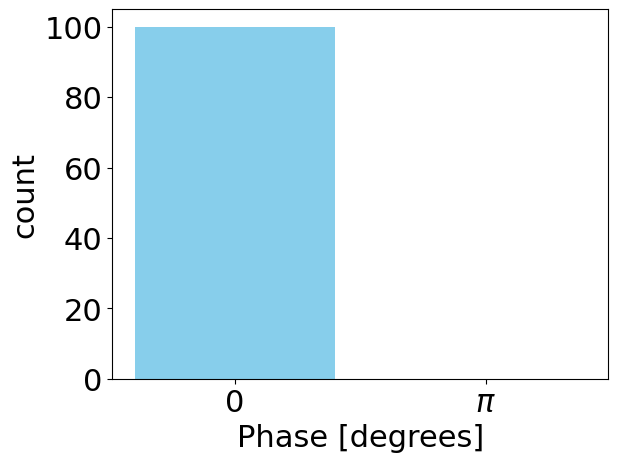

In [142]:
phases = []
for i in range(100):
    statevector_simulator = Aer.get_backend('statevector_simulator')
    job_sv = statevector_simulator.run(transpile(circuit1, statevector_simulator), shots=1000)
    result_sv = job_sv.result()
    statevector = np.array(result_sv.get_statevector())
    phases.append(get_phase(statevector))
phases = np.array(phases)
zeros = phases[phases == 0]
pis = phases[phases > 0]
plt.figure()
plt.xlabel('Phase [degrees]')
plt.ylabel('count')
plt.bar(['0', r'$\pi$'], [len(zeros), len(pis)], color=['skyblue', 'salmon'])
plt.show()

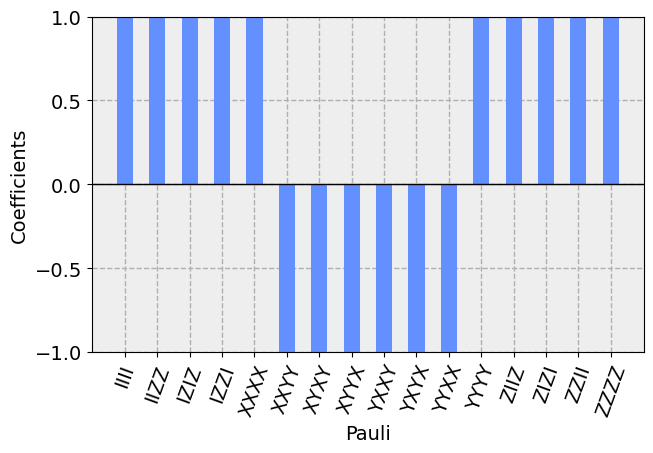

In [143]:
statevector_simulator = Aer.get_backend('statevector_simulator')
job_sv = statevector_simulator.run(transpile(circuit1, statevector_simulator), shots=1000)
result_sv = job_sv.result()
statevector = np.array(result_sv.get_statevector())
sv = Statevector(statevector)
rho = partial_trace(DensityMatrix(sv), [4])
plot_state_paulivec(rho)

In [144]:
circuiti = circuit1.copy()

def get_expectation(circuit, op_str, num_iter=100):
    counts = []
    for i in range(num_iter):
        statevector_simulator = Aer.get_backend('statevector_simulator')
        job_sv = statevector_simulator.run(transpile(circuit, statevector_simulator), shots=100)
        result_sv = job_sv.result()
        statevector = np.array(result_sv.get_statevector())
        sv = Statevector(statevector)
        rho = DensityMatrix(sv)
        counts.append(rho.expectation_value(SparsePauliOp(op_str)))
    return np.mean(counts).real
#print(get_expectation(circuit1, "IIZZ"))
operators = ["IIZZ", "IZZII", "ZZII", "ZIZI", "IZIZ", "ZIIZ", "XXXX", "ZZZZ", "YYYY", "YXYX", "YYXX", "YXXY", "XXYY", "XYYX", "XYXY"]
exps = []
for op in operators:
    exps.append(get_expectation(circuit1, op))

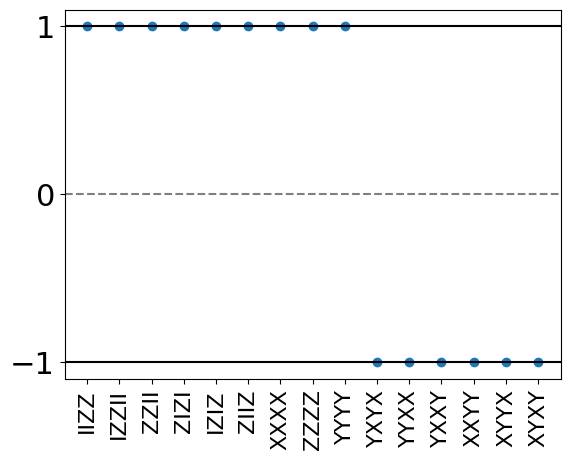

In [145]:
spacing = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
plt.figure()
plt.scatter(spacing, exps)
plt.axhline(y = 1, c='black')
plt.axhline(y = -1, c='black')
plt.axhline(y = 0, alpha=0.5, c='black', linestyle='--')
plt.yticks([-1, 0, 1])
plt.xticks(ticks=spacing, labels=operators, fontsize=16, rotation= 90)
plt.show()

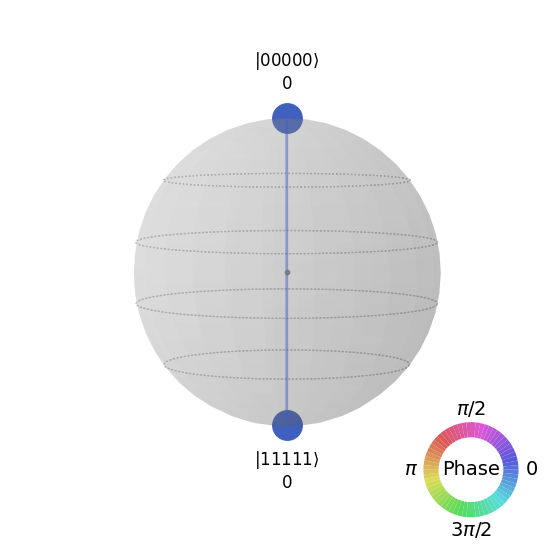

In [146]:
aux = QuantumRegister(1, 'aux') 
data = QuantumRegister(5, 'data') 
c_aux = ClassicalRegister(1, 'c_aux')
circuit11 = QuantumCircuit(data, aux, c_aux)

circuit11.barrier()
circuit11.h(aux[0])
circuit11.barrier()
for i in range(5):
    circuit11.cx(aux[0], data[i])
circuit11.barrier()
circuit11.h(aux[0])
circuit11.measure(aux[0], c_aux[0])
circuit11.barrier()
#circuit1.z(data[0])
circuit11.cz(aux[0], data[0])
circuit11.draw('mpl')

statevector_simulator = Aer.get_backend('statevector_simulator')
job_sv = statevector_simulator.run(transpile(circuit11, statevector_simulator), shots=1000)
result_sv = job_sv.result()
statevector = np.array(result_sv.get_statevector())
logical_plus_sv = partial_trace(Statevector(statevector), [5])
plot_state_qsphere(logical_plus_sv, show_state_phases=True)

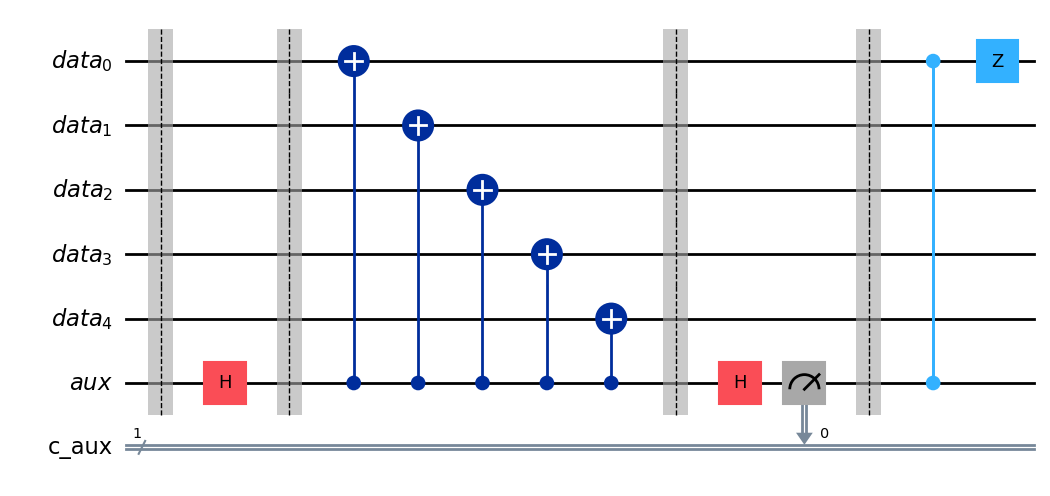

In [147]:
aux = QuantumRegister(1, 'aux') 
data = QuantumRegister(5, 'data') 
c_aux = ClassicalRegister(1, 'c_aux')
circuit111 = QuantumCircuit(data, aux, c_aux)

circuit111.barrier()
circuit111.h(aux[0])
circuit111.barrier()
for i in range(5):
    circuit111.cx(aux[0], data[i])
circuit111.barrier()
circuit111.h(aux[0])
circuit111.measure(aux[0], c_aux[0])
circuit111.barrier()
#circuit1.z(data[0])
circuit111.cz(aux[0], data[0])
circuit111.z(data[0])
circuit111.draw('mpl')

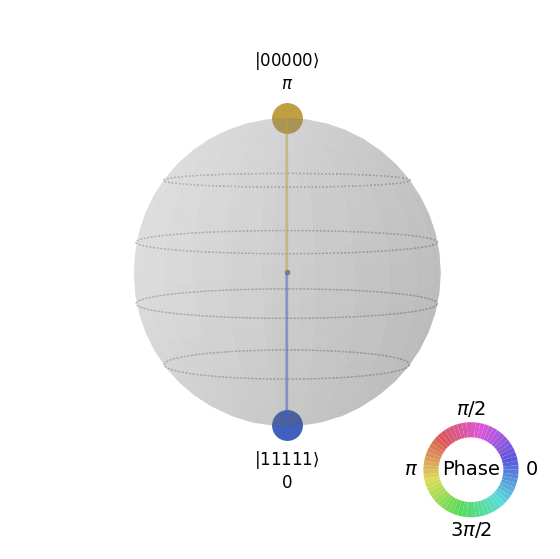

In [148]:
statevector_simulator = Aer.get_backend('statevector_simulator')
job_sv = statevector_simulator.run(transpile(circuit111, statevector_simulator), shots=1000)
result_sv = job_sv.result()
statevector = np.array(result_sv.get_statevector())
logical_minus_sv = partial_trace(Statevector(statevector), [5])
plot_state_qsphere(logical_minus_sv, show_state_phases=True)

# Fig 3 (Non-FT Preparation)

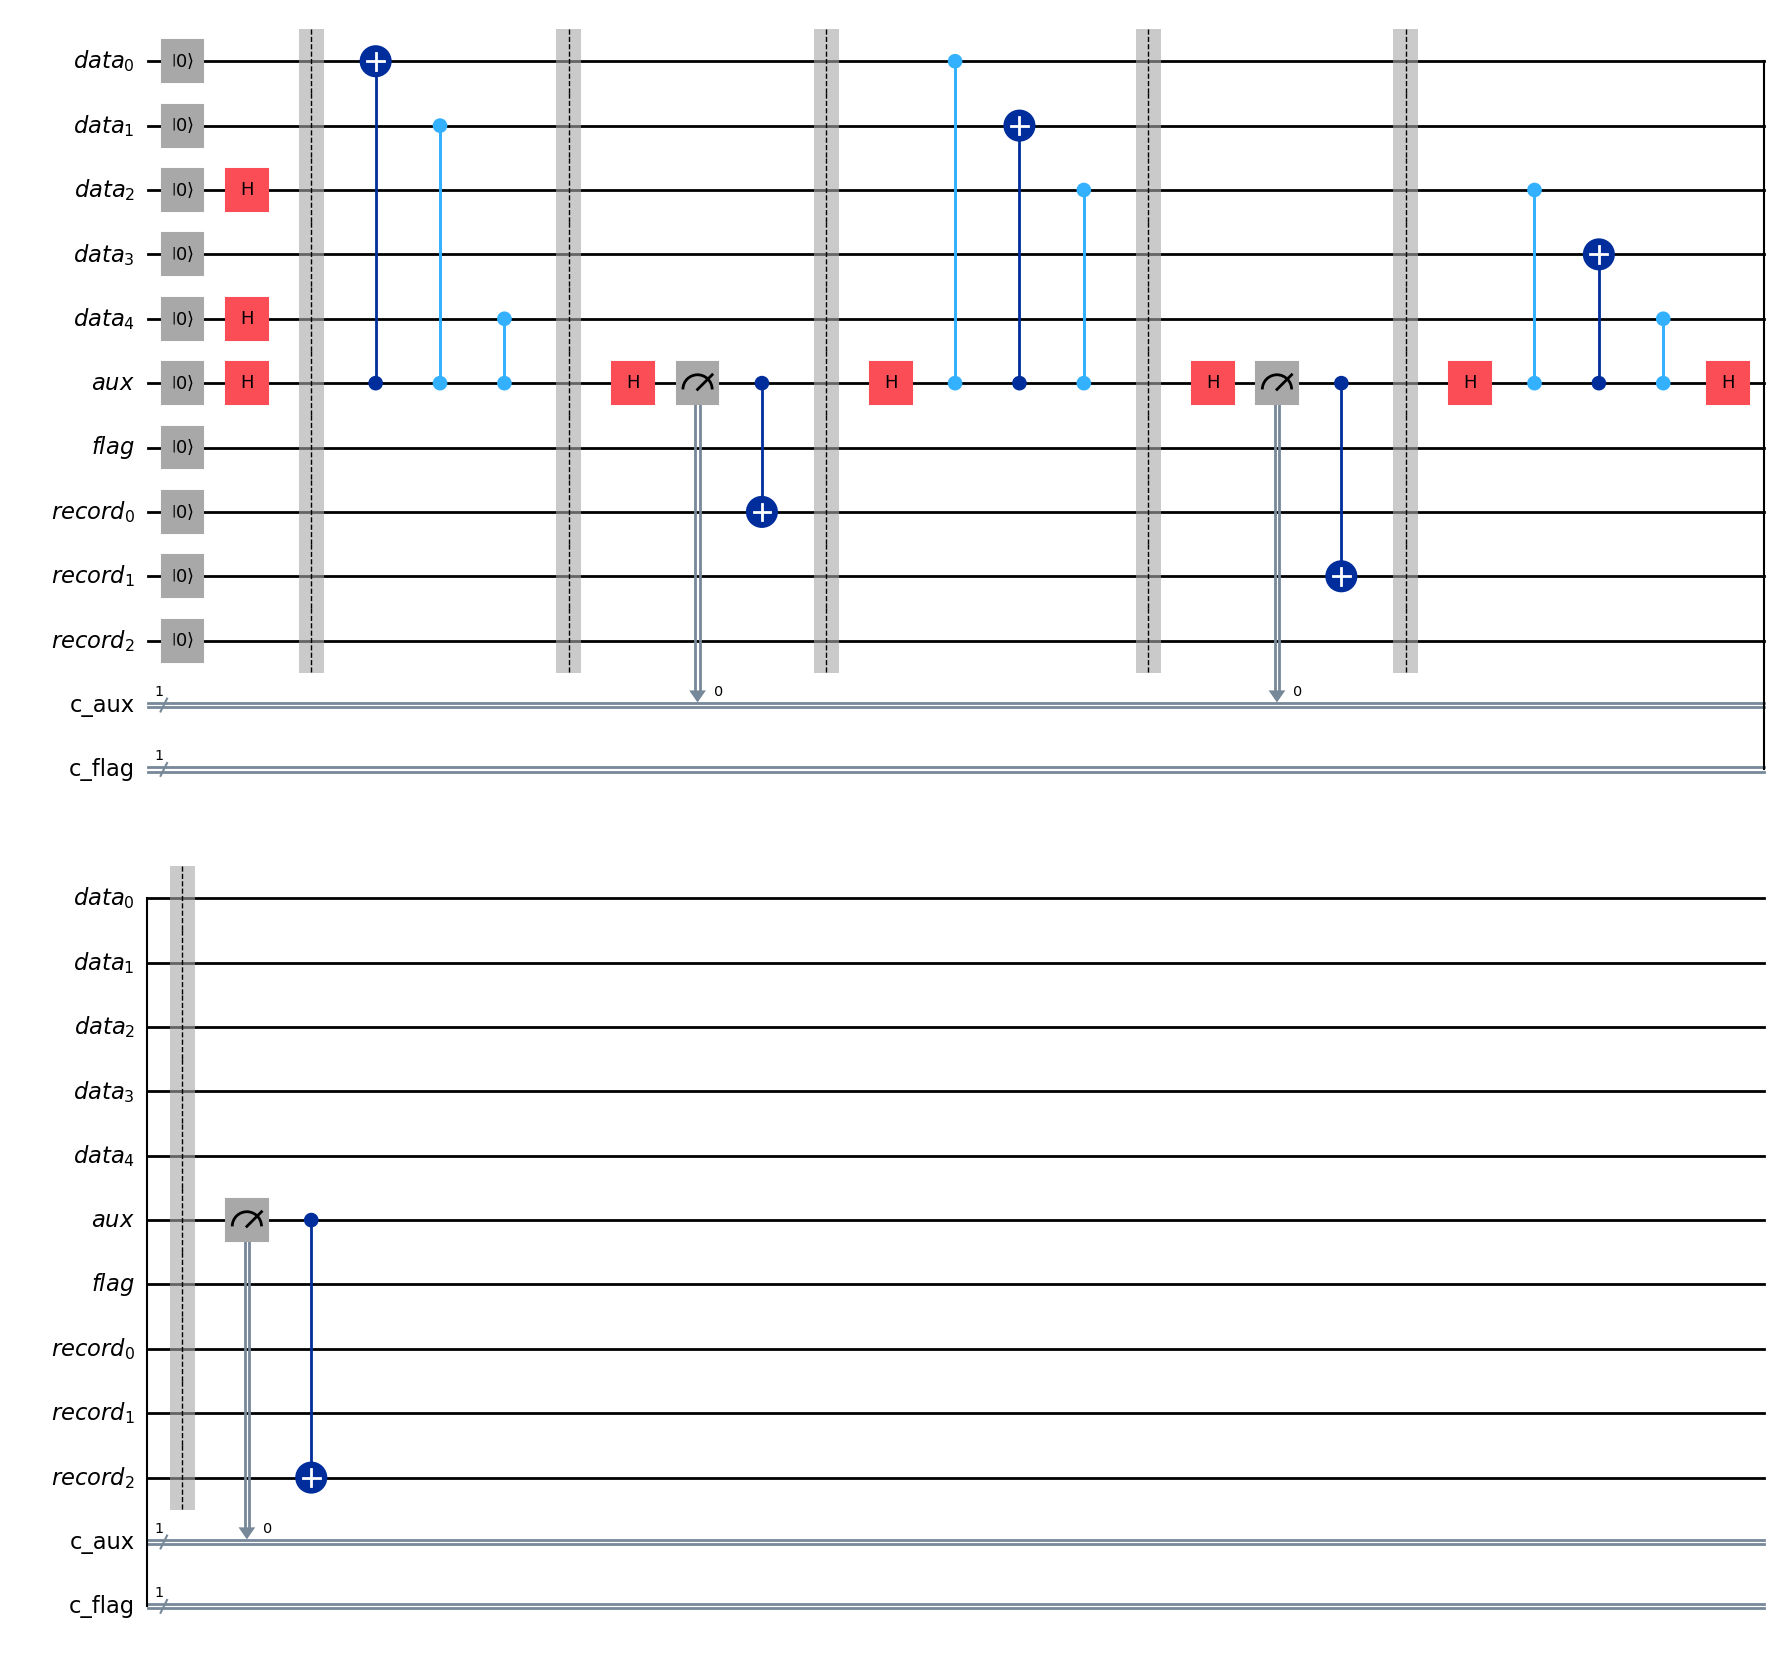

In [149]:
# Quantum + classical registers
aux = QuantumRegister(1, 'aux')         
flag = QuantumRegister(1, 'flag')        
data = QuantumRegister(5, 'data')        
record = QuantumRegister(3, 'record')    
c_aux = ClassicalRegister(1, 'c_aux')  # Store 3 measurement results
c_flag = ClassicalRegister(1, 'c_flag')

# Full circuit = body of while loop
body = QuantumCircuit(data, aux, flag, record, c_aux, c_flag, name="circuit2")

body.reset(data)
body.reset(aux)
body.reset(flag)
body.reset(record)
# Step 1
body.h(aux[0])
body.h(data[2])
body.h(data[4])
body.barrier()

body.cx(aux[0], data[0])
body.cz(aux[0], data[1])
body.cz(aux[0], data[4])
body.barrier()

body.h(aux[0])
body.measure(aux[0], c_aux[0])  # 1st measurement
body.cx(aux[0], record[0])
body.barrier()

# Step 2
body.h(aux[0])
body.cz(aux[0], data[0])
body.cx(aux[0], data[1])
body.cz(aux[0], data[2])
body.barrier()
body.h(aux[0])
body.measure(aux[0], c_aux[0])  # 2nd measurement
body.cx(aux[0], record[1])
body.barrier()

# Step 3
body.h(aux[0])
body.cz(aux[0], data[2])
body.cx(aux[0], data[3])
body.cz(aux[0], data[4])
body.h(aux[0])
body.barrier()
body.measure(aux[0], c_aux[0])  # 3rd measurement
body.cx(aux[0], record[2])


body.draw('mpl')


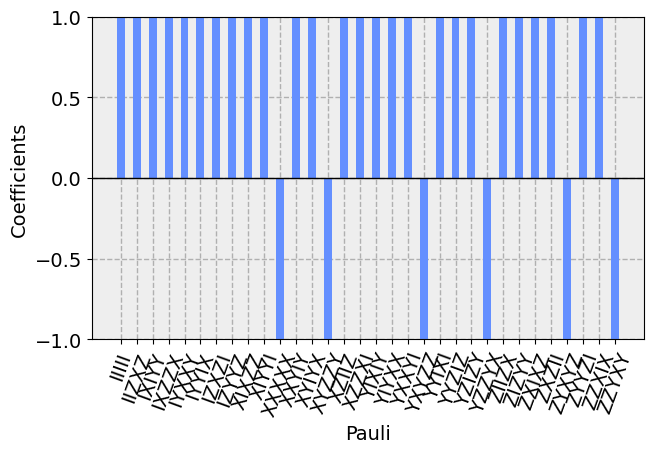

In [150]:
statevector_simulator = Aer.get_backend('statevector_simulator')
job_sv = statevector_simulator.run(transpile(body, statevector_simulator), shots=100)
result_sv = job_sv.result()
statevector = np.array(result_sv.get_statevector())
sv = partial_trace(Statevector(statevector), [0, 1, 2, 3, 4, 5, 6])
record_state = list(sv.probabilities_dict().keys())[0]


while record_state != '000':
    statevector_simulator = Aer.get_backend('statevector_simulator')
    job_sv = statevector_simulator.run(transpile(body, statevector_simulator), shots=100)
    result_sv = job_sv.result()
    statevector = np.array(result_sv.get_statevector())
    sv = partial_trace(Statevector(statevector), [0, 1, 2, 3, 4, 5, 6])
    record_state = list(sv.probabilities_dict().keys())[0]
logical_minus_sv = partial_trace(Statevector(statevector), [5, 6, 7, 8, 9])
plot_state_paulivec(logical_minus_sv)


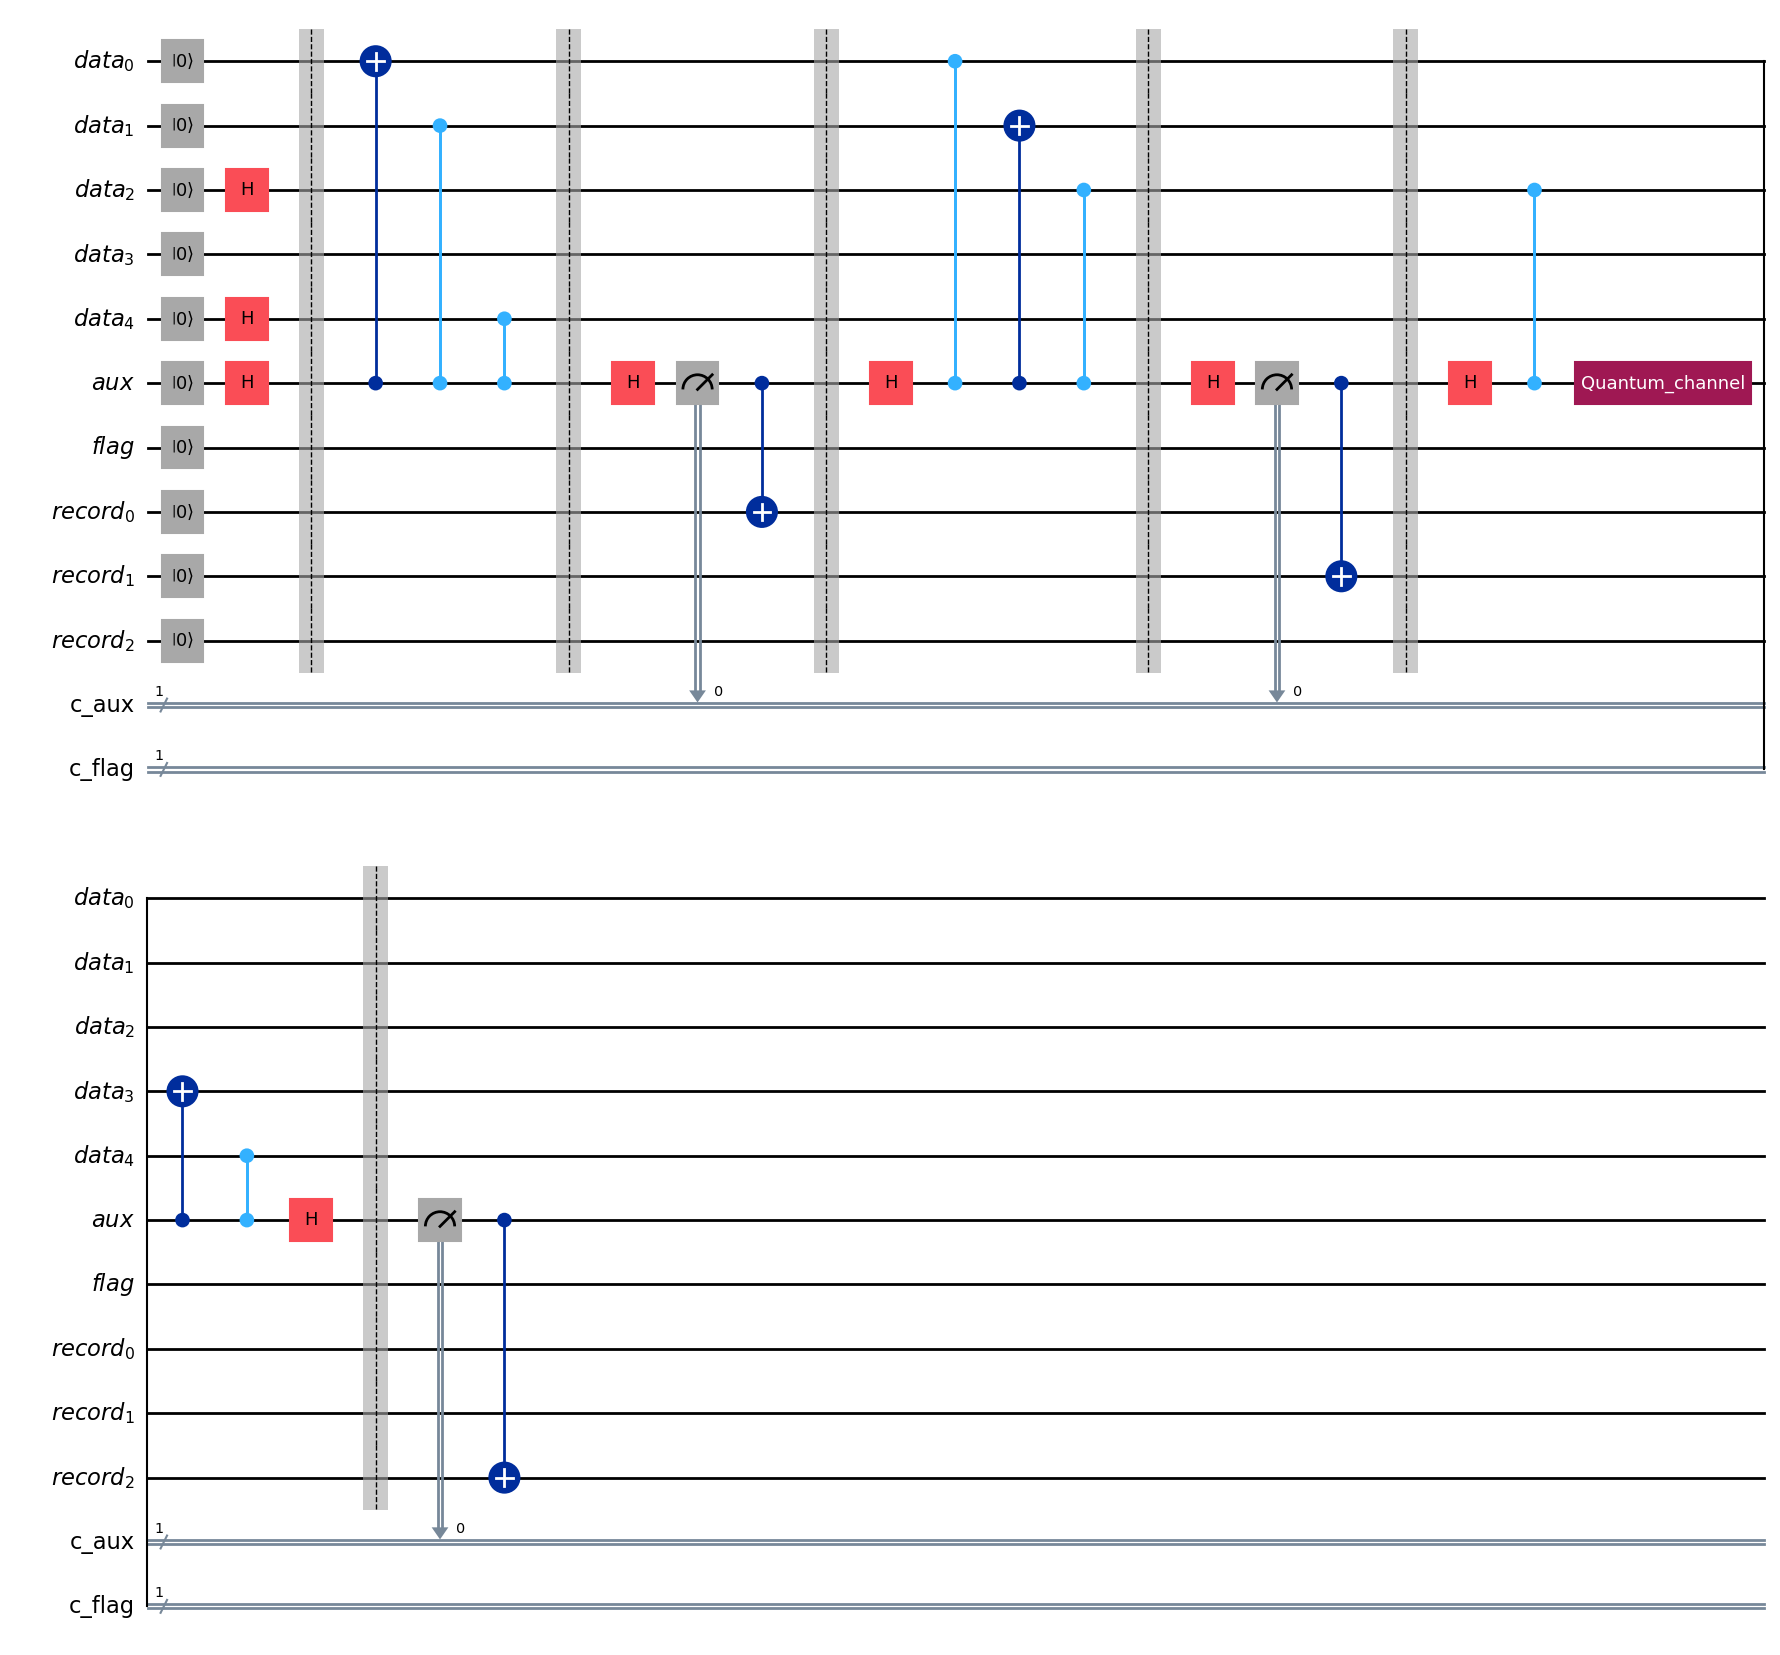

In [930]:
# introducing error
# Quantum + classical registers
aux = QuantumRegister(1, 'aux')         
flag = QuantumRegister(1, 'flag')        
data = QuantumRegister(5, 'data')        
record = QuantumRegister(3, 'record')    
c_aux = ClassicalRegister(1, 'c_aux')  # Store 3 measurement results
c_flag = ClassicalRegister(1, 'c_flag')

# Full circuit = body of while loop
body = QuantumCircuit(data, aux, flag, record, c_aux, c_flag, name="circuit2")

QE =  QuantumError([((IGate(), [0]), 0.4), ((XGate(), [0]), 0.2), ((YGate(), [0]), 0.2), ((ZGate(), [0]), 0.2)])
# we introduce here a noisy quantum channel as our source of error, in the actual experiment, 
# their sources of error may come from imperfections when preparing the state and is some unknow quantum channel
# This error can be seen on Fig. 2 of the paper, also why we cannot do the same fidelity test; this is my understanding but please check on this

body.reset(data)
body.reset(aux)
body.reset(flag)
body.reset(record)
# Step 1
body.h(aux[0])
body.h(data[2])
body.h(data[4])
body.barrier()

body.cx(aux[0], data[0])
body.cz(aux[0], data[1])
body.cz(aux[0], data[4])
body.barrier()

body.h(aux[0])
body.measure(aux[0], c_aux[0])  # 1st measurement
body.cx(aux[0], record[0])
body.barrier()

# Step 2
body.h(aux[0])
body.cz(aux[0], data[0])
body.cx(aux[0], data[1])
body.cz(aux[0], data[2])
body.barrier()
body.h(aux[0])
body.measure(aux[0], c_aux[0])  # 2nd measurement
body.cx(aux[0], record[1])
body.barrier()

# Step 3
body.h(aux[0])
body.cz(aux[0], data[2])
#body.x(aux[0])
body.append(QE, aux)
body.cx(aux[0], data[3])
body.cz(aux[0], data[4])
body.h(aux[0])
body.barrier()
body.measure(aux[0], c_aux[0])  # 3rd measurement
body.cx(aux[0], record[2])


body.draw('mpl')

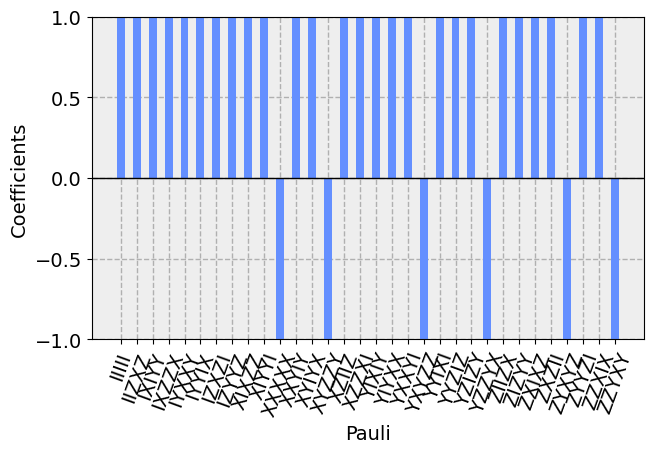

In [931]:
# can run several times to get an errorneous state

statevector_simulator = Aer.get_backend('statevector_simulator')
job_sv = statevector_simulator.run(transpile(body, statevector_simulator), shots=100)
result_sv = job_sv.result()
statevector = np.array(result_sv.get_statevector())
sv = partial_trace(Statevector(statevector), [0, 1, 2, 3, 4, 5, 6])
record_state = list(sv.probabilities_dict().keys())[0]


while record_state != '000':
    statevector_simulator = Aer.get_backend('statevector_simulator')
    job_sv = statevector_simulator.run(transpile(body, statevector_simulator), shots=100)
    result_sv = job_sv.result()
    statevector = np.array(result_sv.get_statevector())
    sv = partial_trace(Statevector(statevector), [0, 1, 2, 3, 4, 5, 6])
    record_state = list(sv.probabilities_dict().keys())[0]
errorneous_sv = partial_trace(Statevector(statevector), [5, 6, 7, 8, 9])
plot_state_paulivec(errorneous_sv)

In [932]:
#takes around 10m - 20m

# get the success rate for non-FT scheme given the quantum error defined ealier through iteration

def get_sv_nft(body):
    statevector_simulator = Aer.get_backend('statevector_simulator')
    job_sv = statevector_simulator.run(transpile(body, statevector_simulator), shots=100)
    result_sv = job_sv.result()
    statevector = np.array(result_sv.get_statevector())
    sv = partial_trace(Statevector(statevector), [0, 1, 2, 3, 4, 5, 6])
    record_state = list(sv.probabilities_dict().keys())[0]


    while record_state != '000':
        statevector_simulator = Aer.get_backend('statevector_simulator')
        job_sv = statevector_simulator.run(transpile(body, statevector_simulator), shots=100)
        result_sv = job_sv.result()
        statevector = np.array(result_sv.get_statevector())
        sv = partial_trace(Statevector(statevector), [0, 1, 2, 3, 4, 5, 6])
        record_state = list(sv.probabilities_dict().keys())[0]
    return partial_trace(Statevector(statevector), [5, 6, 7, 8, 9])

num_iter = 1000
successes = 0
for i in range(num_iter):
    if check_state(get_sv_nft(body)):
        successes += 1
print(f'the success rate of preparing the desired logical state is {successes / num_iter}')
nft_success_rate = successes / num_iter

the success rate of preparing the desired logical state is 0.396


# Fig 3 (FT Preparation)

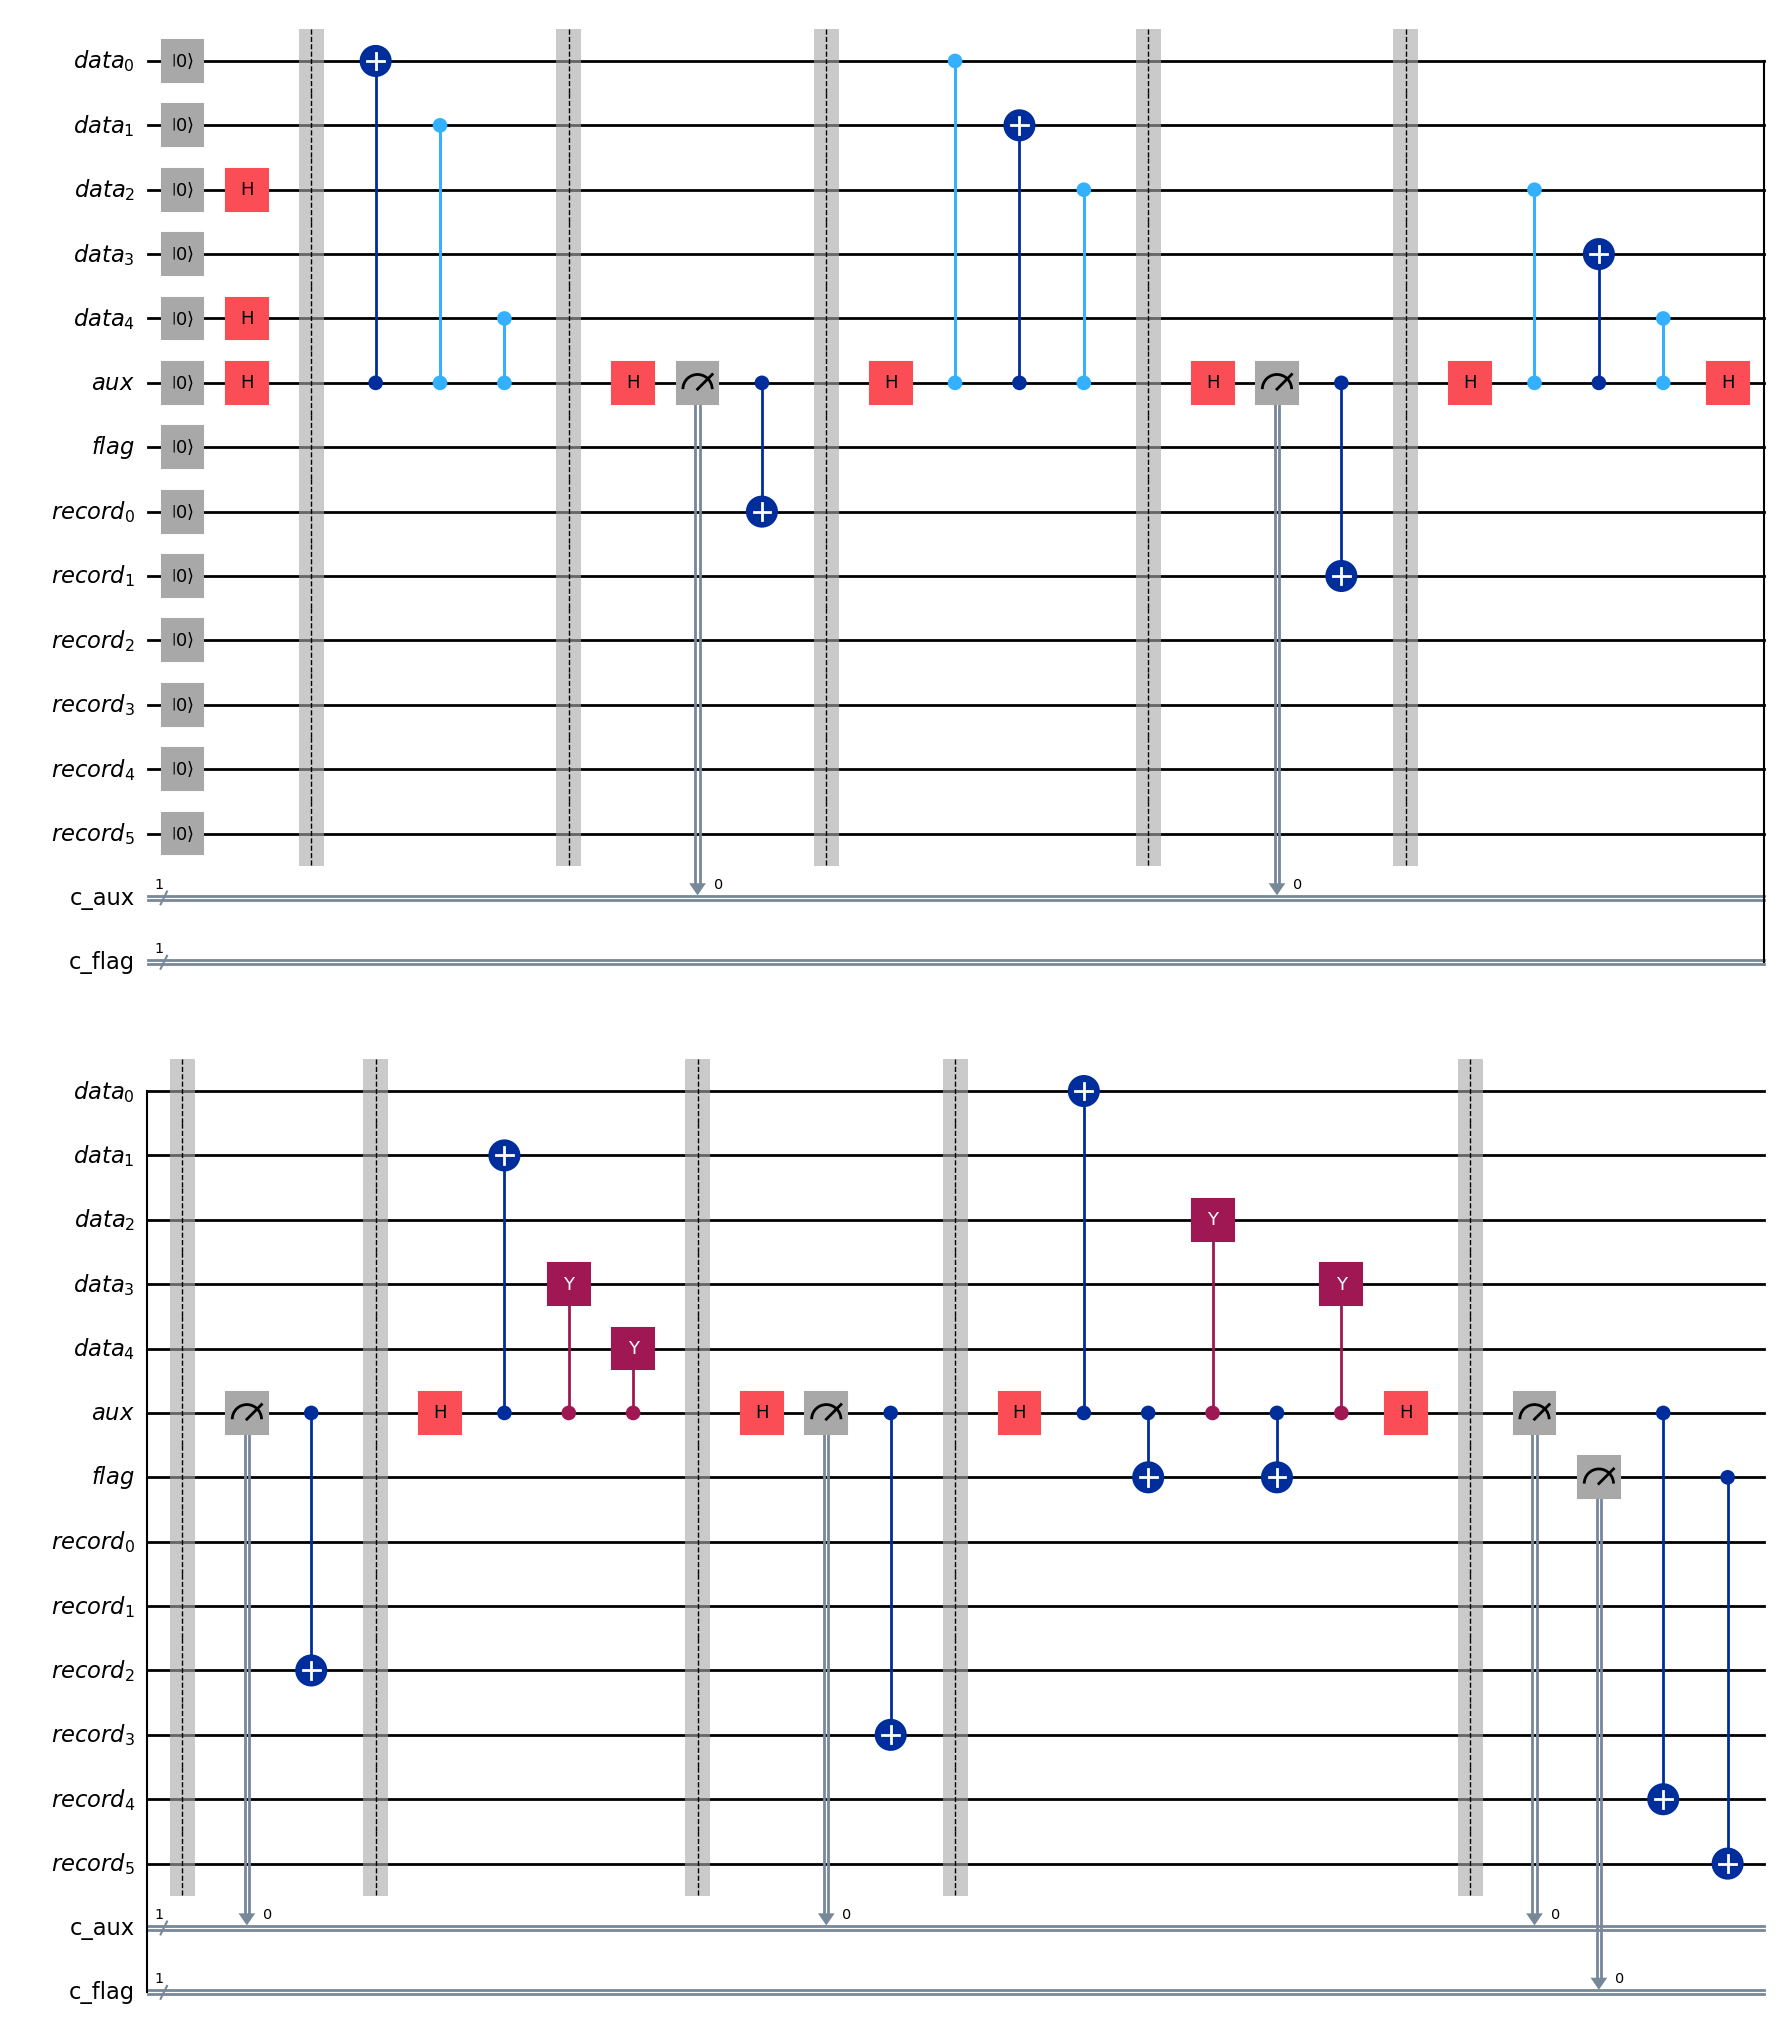

In [216]:
aux = QuantumRegister(1, 'aux')         
flag = QuantumRegister(1, 'flag')        

data = QuantumRegister(5, 'data')        


c_aux = ClassicalRegister(1, 'c_aux')   
c_flag = ClassicalRegister(1, 'c_flag')
#c_data = ClassicalRegister(4, 'c_data')   

# Quantum + classical registers
aux = QuantumRegister(1, 'aux')         
flag = QuantumRegister(1, 'flag')        
data = QuantumRegister(5, 'data')        
record = QuantumRegister(6, 'record')    
c_aux = ClassicalRegister(1, 'c_aux')  # Store 3 measurement results
c_flag = ClassicalRegister(1, 'c_flag')

# Full circuit = body of while loop
body = QuantumCircuit(data, aux, flag, record, c_aux, c_flag, name="circuit2")

body.reset(data)
body.reset(aux)
body.reset(flag)
body.reset(record)
# Step 1
body.h(aux[0])
body.h(data[2])
body.h(data[4])
body.barrier()

body.cx(aux[0], data[0])
body.cz(aux[0], data[1])
body.cz(aux[0], data[4])
body.barrier()

body.h(aux[0])
body.measure(aux[0], c_aux[0])  # 1st measurement
body.cx(aux[0], record[0])
body.barrier()

# Step 2
body.h(aux[0])
body.cz(aux[0], data[0])
body.cx(aux[0], data[1])
body.cz(aux[0], data[2])
body.barrier()
body.h(aux[0])
body.measure(aux[0], c_aux[0])  # 2nd measurement
body.cx(aux[0], record[1])
body.barrier()

# Step 3
body.h(aux[0])
body.cz(aux[0], data[2])
body.cx(aux[0], data[3])
body.cz(aux[0], data[4])
body.h(aux[0])
body.barrier()
body.measure(aux[0], c_aux[0])  # 3rd measurement
body.cx(aux[0], record[2])

body.barrier()
body.h(aux[0])
body.cx(aux[0], data[1])
body.cy(aux[0], data[3])
body.cy(aux[0], data[4])
body.barrier()
body.h(aux[0])
body.measure(aux[0], c_aux[0])
body.cx(aux[0], record[3])


body.barrier()
body.h(aux[0])
body.cx(aux[0], data[0])
body.cx(aux[0], flag[0])
body.cy(aux[0], data[2])
body.cx(aux[0], flag[0])
body.cy(aux[0], data[3])
body.h(aux[0])
body.barrier()
body.measure(aux[0], c_aux[0])
body.cx(aux[0], record[4])
body.measure(flag[0], c_flag)
body.cx(flag[0], record[5])


#circuit.measure(aux[0], c_aux)
body.draw('mpl')


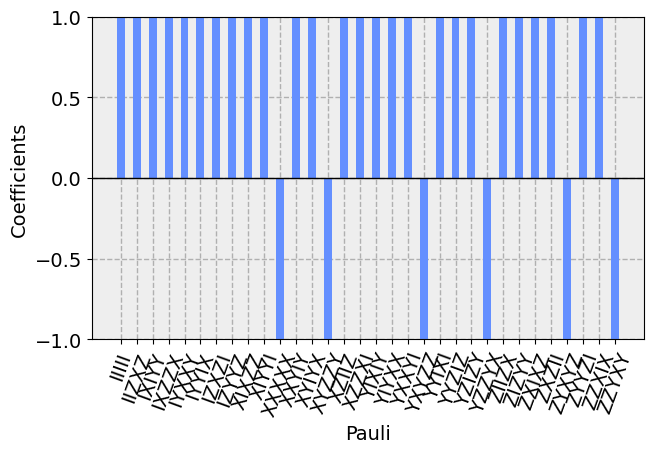

In [217]:
statevector_simulator = Aer.get_backend('statevector_simulator')
job_sv = statevector_simulator.run(transpile(body, statevector_simulator), shots=100)
result_sv = job_sv.result()
statevector = np.array(result_sv.get_statevector())
sv = partial_trace(Statevector(statevector), [0, 1, 2, 3, 4, 5, 6])
record_state = list(sv.probabilities_dict().keys())[0]

while record_state != '000000':
    statevector_simulator = Aer.get_backend('statevector_simulator')
    job_sv = statevector_simulator.run(transpile(body, statevector_simulator), shots=100)
    result_sv = job_sv.result()
    statevector = np.array(result_sv.get_statevector())
    sv = partial_trace(Statevector(statevector), [0, 1, 2, 3, 4, 5, 6])
    record_state = list(sv.probabilities_dict().keys())[0]
logical_minus_sv = partial_trace(Statevector(statevector), [5, 6, 7, 8, 9, 10, 11, 12])
plot_state_paulivec(logical_minus_sv)

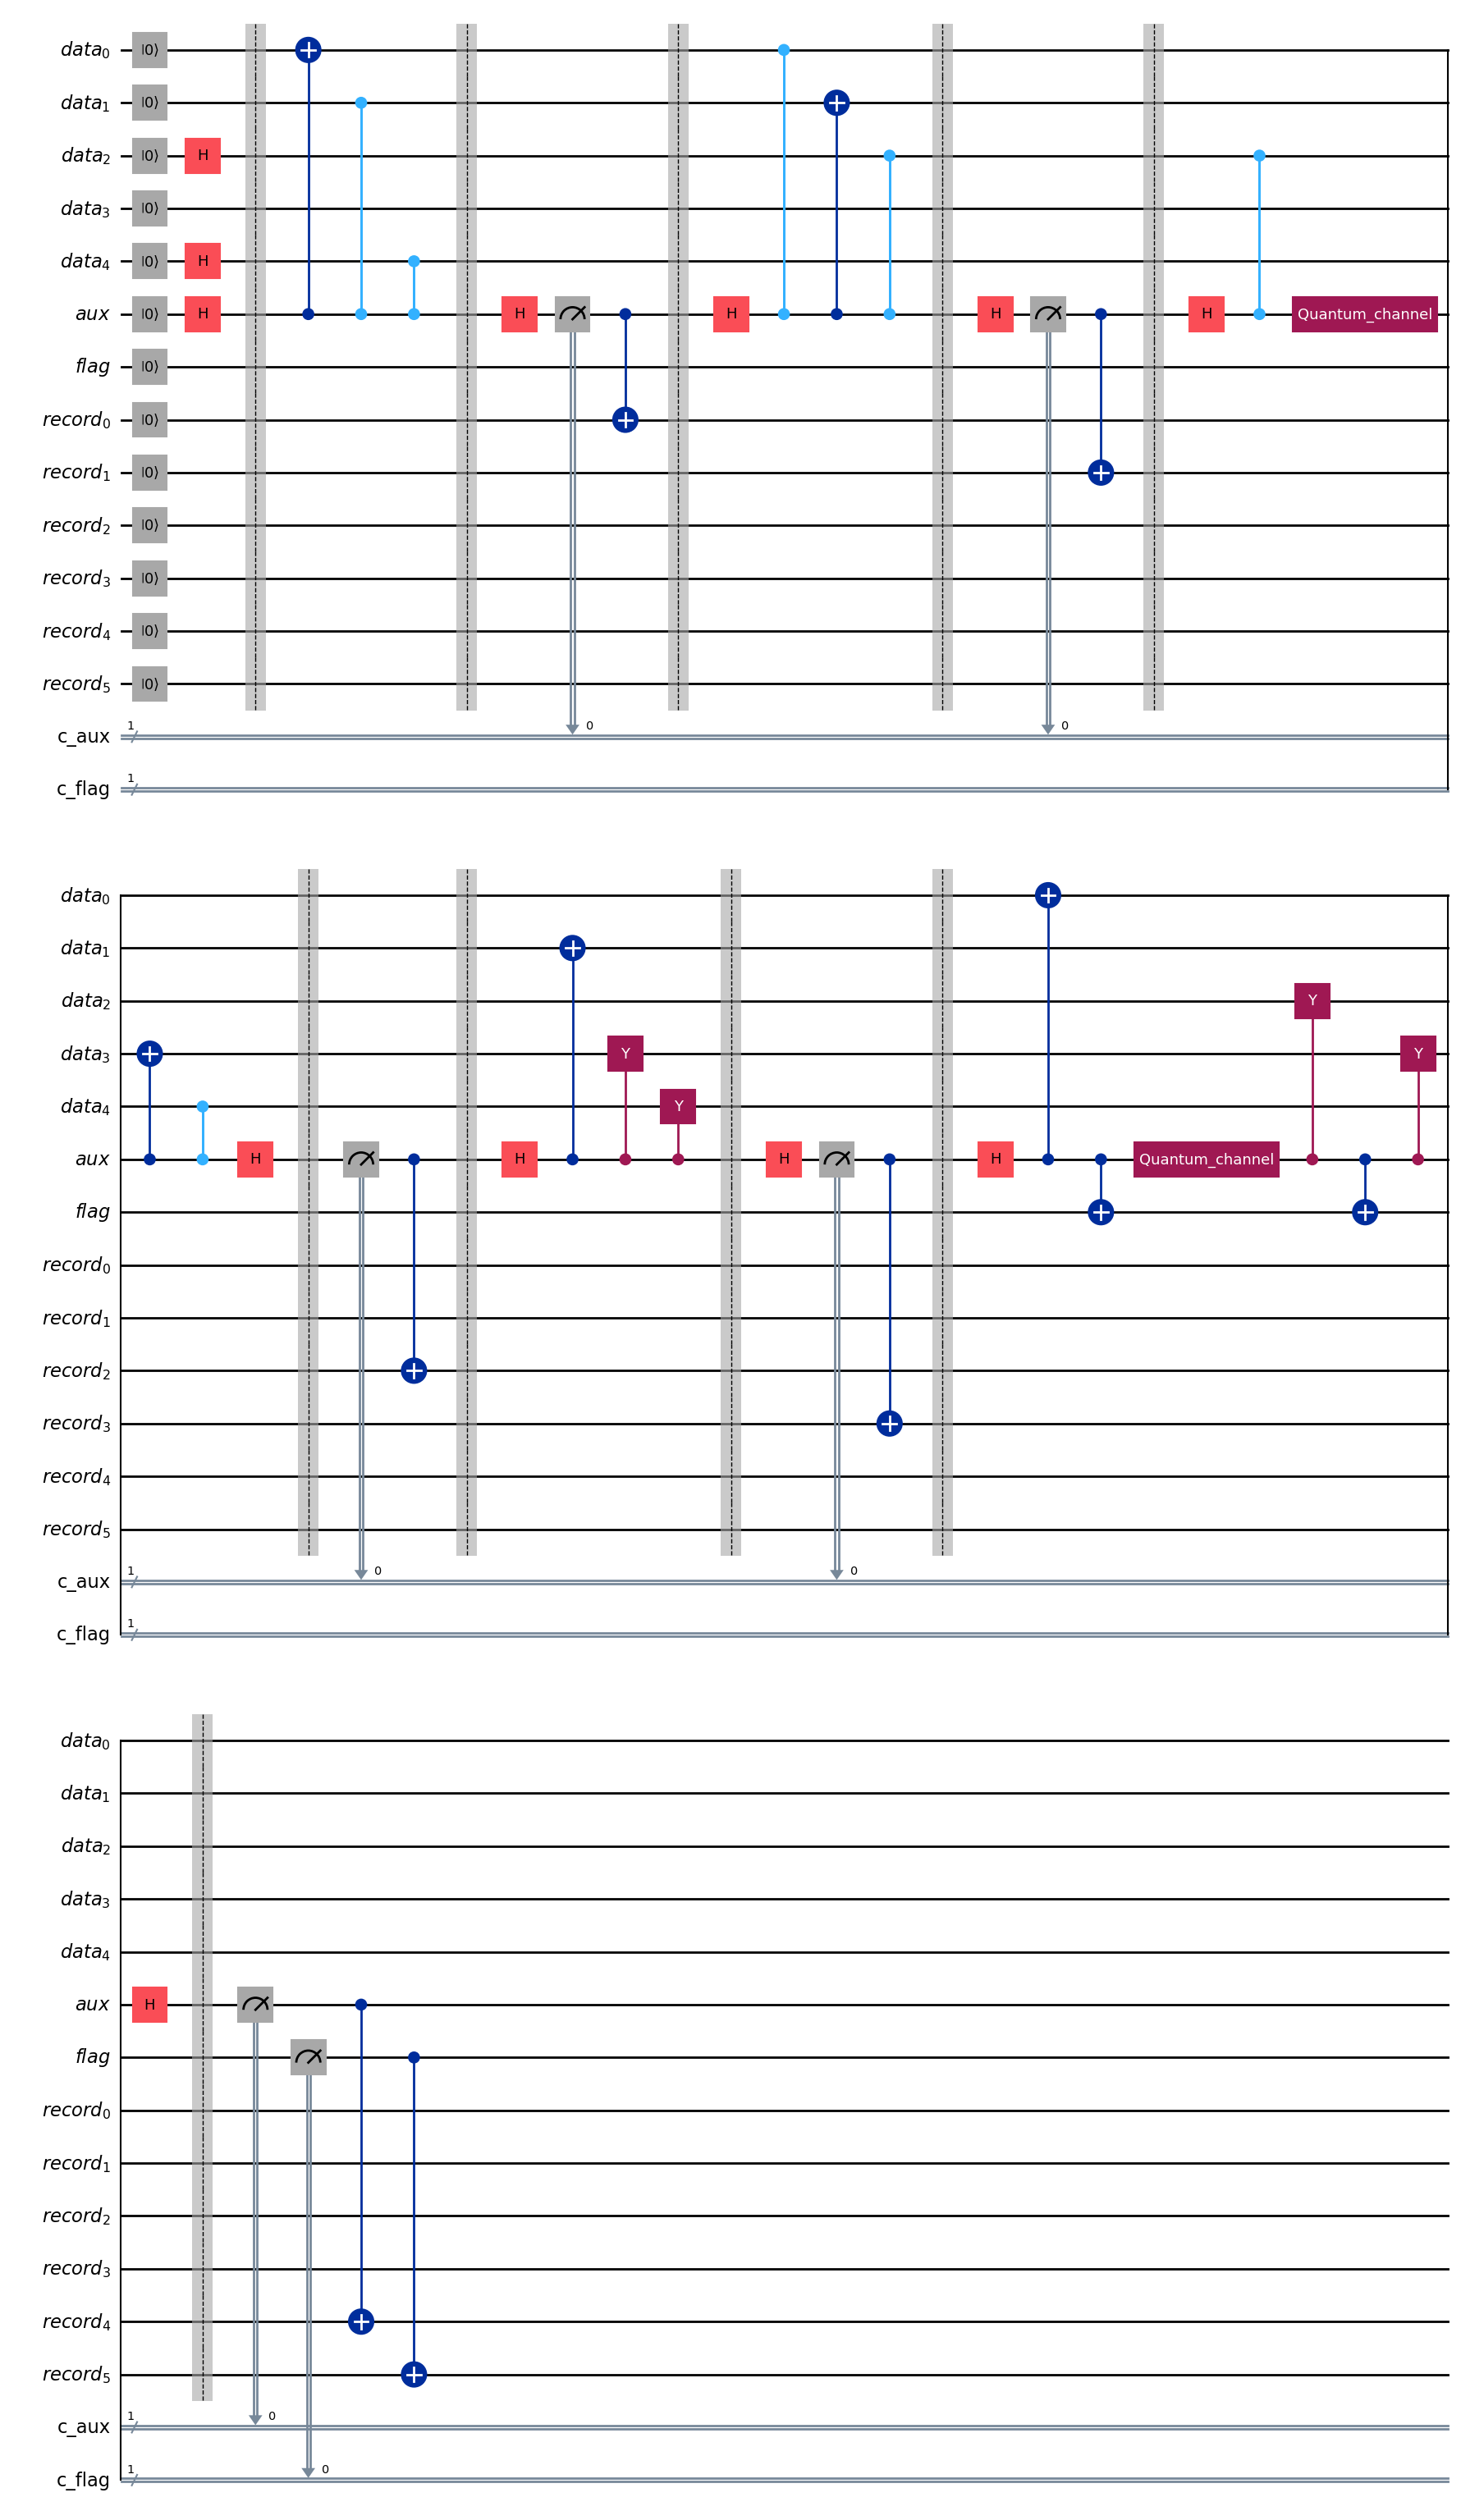

In [921]:
aux = QuantumRegister(1, 'aux')         
flag = QuantumRegister(1, 'flag')        

data = QuantumRegister(5, 'data')        


c_aux = ClassicalRegister(1, 'c_aux')   
c_flag = ClassicalRegister(1, 'c_flag')
#c_data = ClassicalRegister(4, 'c_data')   



# Quantum + classical registers
aux = QuantumRegister(1, 'aux')         
flag = QuantumRegister(1, 'flag')        
data = QuantumRegister(5, 'data')        
record = QuantumRegister(6, 'record')    
c_aux = ClassicalRegister(1, 'c_aux')  # Store 3 measurement results
c_flag = ClassicalRegister(1, 'c_flag')

QE1 =  QuantumError([((IGate(), [0]), 0.4), ((XGate(), [0]), 0.2), ((YGate(), [0]), 0.2), ((ZGate(), [0]), 0.2)])
QE2 =  QuantumError([((IGate(), [0]), 0.4), ((XGate(), [0]), 0.2), ((YGate(), [0]), 0.2), ((ZGate(), [0]), 0.2)])

# Full circuit = body of while loop
body = QuantumCircuit(data, aux, flag, record, c_aux, c_flag, name="circuit2")

body.reset(data)
body.reset(aux)
body.reset(flag)
body.reset(record)
# Step 1
body.h(aux[0])
body.h(data[2])
body.h(data[4])
body.barrier()

body.cx(aux[0], data[0])
body.cz(aux[0], data[1])
body.cz(aux[0], data[4])
body.barrier()

body.h(aux[0])
body.measure(aux[0], c_aux[0])  # 1st measurement
body.cx(aux[0], record[0])
body.barrier()

# Step 2
body.h(aux[0])
body.cz(aux[0], data[0])
body.cx(aux[0], data[1])
body.cz(aux[0], data[2])
body.barrier()
body.h(aux[0])
body.measure(aux[0], c_aux[0])  # 2nd measurement
body.cx(aux[0], record[1])
body.barrier()

# Step 3
body.h(aux[0])
body.cz(aux[0], data[2])
body.append(QE1, aux)
body.cx(aux[0], data[3])
body.cz(aux[0], data[4])
body.h(aux[0])
body.barrier()
body.measure(aux[0], c_aux[0])  # 3rd measurement
body.cx(aux[0], record[2])

# Step 4
body.barrier()
body.h(aux[0])
body.cx(aux[0], data[1])
body.cy(aux[0], data[3])
body.cy(aux[0], data[4])
body.barrier()
body.h(aux[0])
body.measure(aux[0], c_aux[0])
body.cx(aux[0], record[3])

# Step 5
body.barrier()
body.h(aux[0])
body.cx(aux[0], data[0])
body.cx(aux[0], flag[0])
body.append(QE2, aux)
body.cy(aux[0], data[2])
body.cx(aux[0], flag[0])
body.cy(aux[0], data[3])
body.h(aux[0])
body.barrier()
body.measure(aux[0], c_aux[0])
body.cx(aux[0], record[4])
body.measure(flag[0], c_flag)
body.cx(flag[0], record[5])


#circuit.measure(aux[0], c_aux)
body.draw('mpl')


000010


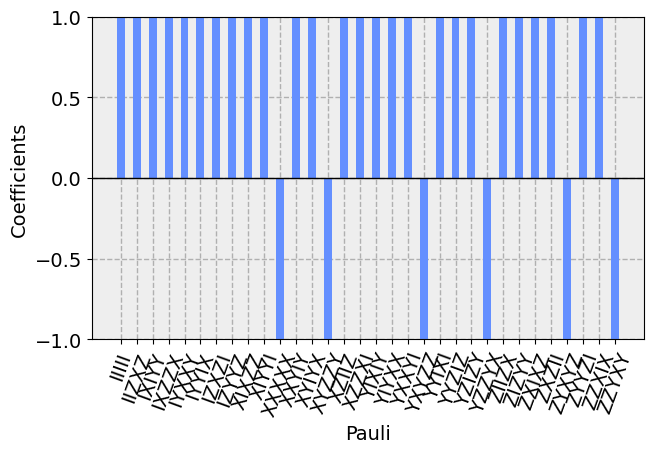

In [923]:
statevector_simulator = Aer.get_backend('statevector_simulator')
job_sv = statevector_simulator.run(transpile(body, statevector_simulator), shots=100)
result_sv = job_sv.result()
statevector = np.array(result_sv.get_statevector())
sv = partial_trace(Statevector(statevector), [0, 1, 2, 3, 4, 5, 6])
record_state = list(sv.probabilities_dict().keys())[0] 
print(record_state)

while record_state != '000000':
    if len(record_state) != 6:
        print('error')
        break
    statevector_simulator = Aer.get_backend('statevector_simulator')
    job_sv = statevector_simulator.run(transpile(body, statevector_simulator), shots=100)
    result_sv = job_sv.result()
    statevector = np.array(result_sv.get_statevector())
    sv = partial_trace(Statevector(statevector), [0, 1, 2, 3, 4, 5, 6])
    record_state = list(sv.probabilities_dict().keys())[0]
errorneous_sv1 = partial_trace(Statevector(statevector), [5, 6, 7, 8, 9, 10, 11, 12])
plot_state_paulivec(errorneous_sv1)



In [926]:
# takes around 90m

def get_sv_ft(body):
    statevector_simulator = Aer.get_backend('statevector_simulator')
    job_sv = statevector_simulator.run(transpile(body, statevector_simulator), shots=100)
    result_sv = job_sv.result()
    statevector = np.array(result_sv.get_statevector())
    sv = partial_trace(Statevector(statevector), [0, 1, 2, 3, 4, 5, 6])
    record_state = list(sv.probabilities_dict().keys())[0]


    while record_state != '000000':
        statevector_simulator = Aer.get_backend('statevector_simulator')
        job_sv = statevector_simulator.run(transpile(body, statevector_simulator), shots=100)
        result_sv = job_sv.result()
        statevector = np.array(result_sv.get_statevector())
        sv = partial_trace(Statevector(statevector), [0, 1, 2, 3, 4, 5, 6])
        record_state = list(sv.probabilities_dict().keys())[0]
    return partial_trace(Statevector(statevector), [5, 6, 7, 8, 9, 10, 11, 12])

num_iter = 1000
successes = 0
for i in range(num_iter):
    if check_state(get_sv_ft(body)):
        successes += 1
print(f'the success rate of preparing the desired logical state is {successes / num_iter}')
ft_success_rate = successes / num_iter

the success rate of preparing the desired logical state is 0.79


0.17320508075688776

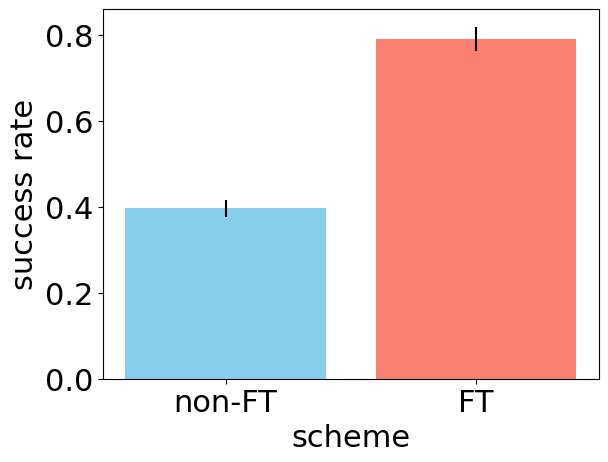

In [939]:
plt.figure()
plt.xlabel('scheme')
plt.ylabel('success rate')
plt.bar(['non-FT', 'FT'], [nft_success_rate, ft_success_rate], color=['skyblue', 'salmon'], yerr = [np.sqrt(nft_success_rate*1000)/1000, np.sqrt(ft_success_rate*1000)/1000]) # success rates with statistical error
plt.show()